In [1]:
import os
import sys
import time
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

from livelossplot import PlotLosses

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import classification_report

from IPython.display import Image

from functools import partial

from tqdm.notebook import tqdm

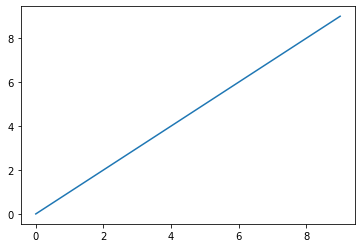

In [2]:
plt.plot(np.arange(10))
plt.show()

In [3]:
# Using model code from Stutz et.al.
os.chdir("/data/adv_geom/drg/")
# from models.classifier import Classifier
from training.train_classifier import TrainClassifier

In [4]:
class EMNIST(Dataset):
    
    def __init__(self, X, y):
        'Initialization'
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        
        return self.X[idx], self.y[idx]

In [5]:
%tb
args = {
    "train_images_file": "/data/adv_geom/datasets/emnist/train_images.h5",
    "train_codes_file": "/data/adv_geom/datasets/emnist/train_labels.h5",
    "test_images_file": "/data/adv_geom/datasets/emnist/test_images.h5",
    "test_codes_file": "/data/adv_geom/datasets/emnist/test_labels.h5",
    "state_file": "/data/adv_geom/dumps/emnist/classifier.pth.tar",
    "label_index": 0,
    "lr_decay": 0.95,
    "weight_decay": 0.0001,
    "training_samples": 160000,
    "validation_samples": 40000,
    "random_samples": True,
    "network_architecture": "mlp",
    "gpu_id": 1
}

sys.argv = ["-" + i + "=" + str(args[i]) if type(args[i]) != type(True) else "-" + i for i in args]


train_clf = TrainClassifier(args=sys.argv)
train_clf.load_data()
train_clf.load_model_and_scheduler()

No traceback available to show.
[0403210727] -- TrainClassifier
[0403210727] [Training] train_images_file=/data/adv_geom/datasets/emnist/train_images.h5
[0403210727] [Training] train_codes_file=/data/adv_geom/datasets/emnist/train_labels.h5
[0403210727] [Training] test_images_file=/data/adv_geom/datasets/emnist/test_images.h5
[0403210727] [Training] test_codes_file=/data/adv_geom/datasets/emnist/test_labels.h5
[0403210727] [Training] state_file=/data/adv_geom/dumps/emnist/classifier.pth.tar
[0403210727] [Training] log_file=/data/adv_geom/dumps/emnist/classifier.log
[0403210727] [Training] training_file=/data/adv_geom/dumps/emnist/training.h5
[0403210727] [Training] testing_file=/data/adv_geom/dumps/emnist/testing.h5
[0403210727] [Training] loss_file=/data/adv_geom/dumps/emnist/loss.png
[0403210727] [Training] error_file=/data/adv_geom/dumps/emnist/error.png
[0403210727] [Training] gradient_file=/data/adv_geom/dumps/emnist/gradient.png
[0403210727] [Training] label_index=0
[0403210727] 

In [6]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def pgd_linf_rand(model, X, y, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)
    
#     model.zero_grad()
    
    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
        
        for t in range(num_iter):
            loss = nn.CrossEntropyLoss()(model(X + delta), y.long())
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()
        
        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta),y.long())
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)
    
#     model.zero_grad()
    return max_delta

In [7]:
def plot_images(X,y,yp,M,N,path=None):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
#     plt.tight_layout()
    if path is None:
        path = "test.png"
    plt.savefig(path)

In [8]:
def get_projection(x, delta, X_train, nn, pca=None, scheme="paper"):
    """
    get projection of a sample on the approximated manifold
    
    this implementation is based on the repository for Stutz et.al.
    as well as what they have written in their paper
    
    input:
    x: sample for which projection is to be computed (numpy)
    nn: nearest neighbor model fitted on the training samples
    pca: if given it refers to the PCA model fitted on random subset of training samples 
    scheme: 
        - "paper": given in Appendix C in the paper
        - "self": based on paper, computed by myself
        - "pca_paper": nn is done using pca vectors then "paper"
        - "pca_self": nn is done using pca vectors then "self"
        - "*_correct": if you want zero correction
    
    returns:
    pi_x: projection of sample onto the manifold
    """
    
    x = x.reshape(1, -1)
    x_latent = x.clone()
    # pca is used only in code but not mentioned in the paper
    # if it is provided, we transform the vectors
    if pca:
        assert scheme[:4] == "pca_"
#         assert X_train.shape[1] == pca.n_features_
        x_latent = pca.transform(x)
        
    nbhrs_idx = nn.kneighbors(x_latent.reshape(1, -1), n_neighbors=50)[1][0]
    nbhrs = X_train[nbhrs_idx]
    
    nbhrs = nbhrs.reshape(nbhrs.shape[0], -1)
    if "paper" in scheme:
        delta = delta.reshape(-1)
    
    norm_nbhrs = None
    sol = None
    if "paper" in scheme:
        norm_nbhrs = nbhrs - nbhrs.mean(axis=0)
#         print(norm_nbhrs.shape, delta.shape)

        sol = np.linalg.lstsq(norm_nbhrs.T, delta, rcond=None)
    elif "self" in scheme:
        # this part does not change in "self"
        norm_nbhrs = nbhrs - nbhrs.mean(axis=0) 
        
        sol = np.linalg.lstsq(norm_nbhrs.T, x.reshape(-1) - nbhrs.mean(axis=0), rcond=None)
        
    beta = sol[0]
    pi_x = np.dot(norm_nbhrs.T, beta) 
    
    if "correct" in scheme:
        pi_x = pi_x + nbhrs.mean(axis=0)
    
    return pi_x
    
    

In [9]:
def get_projections_for_data(X, y, X_train, nn, pca=None, scheme="paper", batch_size=8):
    """get projections for data and get predictions on top of them"""
    
    
    pi_X_set = None
    perturbed_set = None
    orig_set = None
    
    true_labels = None
    raw_X_codes = None
    perturbed_X_codes = None
    pi_X_codes = None
    
    
    
    dataset = EMNIST(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    for (inp, targets) in tqdm(dataloader):
        
        model.cuda()
        
        inp = inp.cuda()
        targets = targets.cuda()
        
        # computing predictions for original images
        model.eval()
        with torch.no_grad():
            
            inp = inp
            raw_pred_codes = model(inp).cpu()
        
#         model.train()
        
        if raw_X_codes is None:
            raw_X_codes = raw_pred_codes
        else:
            raw_X_codes = torch.cat((raw_X_codes, raw_pred_codes), axis=0)
            
        
        # computing perturbations
        delta = pgd_linf_rand(model, inp, targets, 0.1, 1e-2, 40, 10)
#         model.zero_grad()
        delta = delta.cuda()
        
        # perturbed input
        perturbed_inp = inp.detach().clone() + delta
        
        # computing predictions on perturbed input
#         model.eval()
        with torch.no_grad(): 
            perturbed_pred_codes = model(perturbed_inp.permute(0, 3, 1, 2))
#         model.train()
        
        
        inp = inp.detach().cpu()
        targets = targets.detach().cpu()
        delta = delta.detach().cpu()
        
        if true_labels is None:
            true_labels = targets
        else:
            true_labels = torch.cat((true_labels, targets), axis=0)
            
        if orig_set is None:
            orig_set = inp
        else:
            orig_set = torch.cat((orig_set, inp), axis=0)
        
        projected_inp_batch = None
        
        # finding projections
        for i in range(inp.shape[0]):
            
            projected_inp = get_projection(perturbed_inp[i].detach().cpu(), delta[i], X_train, nn, pca, scheme)
            projected_inp = torch.from_numpy(projected_inp)
            
            projected_inp = projected_inp.reshape(1, 28, 28, 1)
            
            if pi_X_set is None:
                pi_X_set = projected_inp
            else:
                pi_X_set = torch.cat((pi_X_set, projected_inp), axis=0)
                
            if projected_inp_batch is None:
                projected_inp_batch = projected_inp
            else:
                projected_inp_batch = torch.cat((projected_inp_batch, projected_inp), axis=0)
                
        projected_inp_batch = projected_inp_batch.cuda()
        
        # computing predictions for projected samples
#         model.eval()
        with torch.no_grad():
            projected_pred_codes = model(projected_inp_batch.permute(0, 3, 1, 2))
#         model.train()
        
        perturbed_pred_codes = perturbed_pred_codes.detach().cpu()
        perturbed_inp = perturbed_inp.detach().cpu()
        projected_pred_codes = projected_pred_codes.cpu()
        projected_inp_batch = projected_inp_batch.cpu()
        
        if perturbed_set is None:
            perturbed_set = perturbed_inp
        else:
            perturbed_set = torch.cat((perturbed_set, perturbed_inp), axis=0)
        
        if perturbed_X_codes is None:
            perturbed_X_codes = perturbed_pred_codes
        else:
            perturbed_X_codes = torch.cat((perturbed_X_codes, perturbed_pred_codes), axis=0)
        
        
        if pi_X_codes is None:
            pi_X_codes = projected_pred_codes
            
        else:
            pi_X_codes = torch.cat((pi_X_codes, projected_pred_codes), axis=0)
        
        
#         print(pi_X_set.shape, perturbed_set.shape, raw_X_codes.shape, perturbed_X_codes.shape, pi_X_codes.shape)
    return orig_set, pi_X_set, perturbed_set, true_labels, raw_X_codes, perturbed_X_codes, pi_X_codes
        
    
# model.cuda()
# rimg = rimg.cuda()
# rcode = rcode.cuda()
# delta = pgd_linf_rand(model, rimg, rcode, 0.1, 1e-2, 40, 10)
# model.cpu()
# rimg = rimg.cpu()
# rcode = rcode.cpu()

In [10]:
model = train_clf.model
X_test = torch.Tensor(train_clf.test_images)
y_test = torch.Tensor(train_clf.test_codes)


In [11]:
"""
Finding nearest neighbours on the manifold
Reference: https://github.com/davidstutz/disentangling-robustness-generalization/blob/220ff8a79a5f08665f4755dc76d4e592ae66c6d6/training/test_attack_classifier.py#L154
"""

'\nFinding nearest neighbours on the manifold\nReference: https://github.com/davidstutz/disentangling-robustness-generalization/blob/220ff8a79a5f08665f4755dc76d4e592ae66c6d6/training/test_attack_classifier.py#L154\n'

In [12]:
X_train = train_clf.train_images
y_train = train_clf.train_codes

USE_PCA = True
num_img_to_fit = 10000

pca = None
NN = None
X_train_latent = None

if USE_PCA:

    # Training a PCA model on randomly sampled 10000 images from the training set
    idx = np.random.randint(0, X_train.shape[0], size=num_img_to_fit)

    pca = IncrementalPCA(n_components=20) # n_components taken from David Stutz's code
    pca.fit(X_train[idx].reshape(X_train[idx].shape[0], -1))

    # Transforming the training set based on the learned PCA model 
    # Note: These will be used to approximate the manifold, since these
    # are what the classifier has been trained on
    X_train_latent = pca.transform(X_train.reshape(X_train.shape[0], -1))

    # Fitting a Nearest Neighbors object on the transformed latent samples
    NN = NearestNeighbors(n_neighbors=50, algorithm='kd_tree')
    NN.fit(X_train_latent)
    
else:
    NN = NearestNeighbors(n_neighbors=50, algorithm="kd_tree")
    NN.fit(X_train.reshape(X_train.shape[0], -1))

In [13]:
# orig_set, pi_X_set, perturbed_set, true_labels, raw_X_codes, perturbed_X_codes, pi_X_codes = get_projections_for_data(X_test,\
#                                                                                                y_test,\
#                                                                                                X_train,\
#                                                                                                NN,\
#                                                                                                pca,\
#                                                                                                scheme="paper_correct",\
#                                                                                                batch_size=8)






In [14]:
# os.mkdir("paper_correct")
# torch.save(orig_set, "paper_correct/orig_set.pkl")
# torch.save(pi_X_set, "paper_correct/pi_X_set.pkl")
# torch.save(perturbed_set, "paper_correct/perturbed_set.pkl")
# torch.save(true_labels, "paper_correct/true_labels.pkl")
# torch.save(raw_X_codes, "paper_correct/raw_X_codes.pkl")
# torch.save(perturbed_X_codes, "paper_correct/perturbed_X_codes.pkl")
# torch.save(pi_X_codes, "paper_correct/pi_X_codes.pkl")

In [15]:
orig_set = torch.load("../dumps/pca_paper_correct/orig_set.pkl")
pi_X_set = torch.load("../dumps/pca_paper_correct/pi_X_set.pkl")
perturbed_set = torch.load("../dumps/pca_paper_correct/perturbed_set.pkl")
true_labels = torch.load("../dumps/pca_paper_correct/true_labels.pkl")
raw_X_codes = torch.load("../dumps/pca_paper_correct/raw_X_codes.pkl")
perturbed_X_codes = torch.load("../dumps/pca_paper_correct/perturbed_X_codes.pkl")
pi_X_codes = torch.load("../dumps/pca_paper_correct/pi_X_codes.pkl")

In [16]:
raw_labels = torch.max(raw_X_codes, axis=1)[1]
perturbed_labels = torch.max(perturbed_X_codes, axis=1)[1]
projected_labels = torch.max(pi_X_codes, axis=1)[1]

In [17]:
print(classification_report(true_labels.long().cpu(), raw_labels.cpu()))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4000
           1       0.99      0.99      0.99      4000
           2       0.99      0.97      0.98      4000
           3       0.98      0.97      0.97      4000
           4       0.94      0.99      0.97      4000
           5       0.98      0.97      0.97      4000
           6       0.99      0.98      0.98      4000
           7       0.96      0.99      0.98      4000
           8       0.98      0.96      0.97      4000
           9       0.97      0.95      0.96      4000

    accuracy                           0.97     40000
   macro avg       0.97      0.97      0.97     40000
weighted avg       0.97      0.97      0.97     40000



In [18]:
print(classification_report(true_labels.cpu(), perturbed_labels.cpu()))

              precision    recall  f1-score   support

         0.0       0.34      0.47      0.39      4000
         1.0       0.00      0.00      0.00      4000
         2.0       0.14      0.14      0.14      4000
         3.0       0.09      0.07      0.08      4000
         4.0       0.11      0.19      0.14      4000
         5.0       0.19      0.21      0.20      4000
         6.0       0.16      0.07      0.10      4000
         7.0       0.03      0.02      0.03      4000
         8.0       0.08      0.11      0.09      4000
         9.0       0.02      0.02      0.02      4000

    accuracy                           0.13     40000
   macro avg       0.12      0.13      0.12     40000
weighted avg       0.12      0.13      0.12     40000



In [19]:
print(classification_report(true_labels.cpu(), projected_labels.cpu()))

              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88      4000
         1.0       0.94      0.96      0.95      4000
         2.0       0.87      0.82      0.85      4000
         3.0       0.85      0.77      0.80      4000
         4.0       0.72      0.85      0.78      4000
         5.0       0.84      0.82      0.83      4000
         6.0       0.94      0.87      0.90      4000
         7.0       0.81      0.82      0.81      4000
         8.0       0.78      0.74      0.76      4000
         9.0       0.70      0.66      0.68      4000

    accuracy                           0.83     40000
   macro avg       0.83      0.83      0.83     40000
weighted avg       0.83      0.83      0.83     40000



# Visualization

In [29]:
ridx = np.random.randint(low=0, high=orig_set.shape[0])
ridx = 27067
rimg = orig_set[ridx:ridx+1].clone()
rtarget = true_labels[ridx]


In [30]:
perturbed_img = perturbed_set[ridx:ridx+1].clone()
delta = perturbed_img[0] - rimg[0]
projection_img = get_projection(perturbed_img[0], delta, X_train, nn=NN, pca=pca, scheme="pca_paper_correct")
projection_img = projection_img.reshape(1, 28, 28, 1)

In [31]:
projection_img = torch.from_numpy(projection_img)


In [32]:
def plot_images(X,y,yp,M,N,path=None):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3), squeeze=False)
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j]))
            plt.setp(title, color=('g' if yp[i*N+j] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
            
model.eval()
imgs = torch.cat((rimg, perturbed_img, projection_img), axis=0)
gt_labels = torch.Tensor((rtarget.item(),)*3).long()
with torch.no_grad():
    imgs = imgs.cuda()
    model = model.cuda()
    logits = model(imgs).detach().cpu()
    pred_labels = logits.max(axis=1)[1]
    imgs = imgs.cpu()
    model = model.cpu()
    
    


In [33]:
pred_labels, gt_labels

(tensor([9, 7, 9]), tensor([9, 9, 9]))

<IPython.core.display.Javascript object>


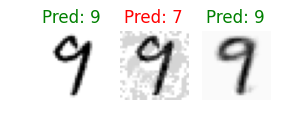

In [34]:
plot_images(imgs, gt_labels, pred_labels, 1, 3)

In [35]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

# projection_img = torch.from_numpy(projection_img)

# imgs = torch.cat((rimg, perturbed_img, projection_img), axis=0)
# plt.figure()
# toplot = imgs.permute(0, 3, 1, 2)
# grid_img = torchvision.utils.make_grid(toplot, nrow=3)
# imgs_plot = plt.imshow(grid_img.permute(1, 2, 0), cmap="gray")

# plt.figure()

def plot_images(X,y,yp,M,N,path=None):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3), squeeze=False)
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j]))
            plt.setp(title, color=('g' if yp[i*N+j] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.show()
            
model.eval()
imgs = torch.cat((rimg, perturbed_img, projection_img), axis=0)
gt_labels = torch.Tensor((rtarget.item(),)*3).long()
with torch.no_grad():
    imgs = imgs.cuda()
    model = model.cuda()
    logits = model(imgs).detach().cpu()
    pred_labels = logits.max(axis=1)[1]
    imgs = imgs.cpu()
    model = model.cpu()

# plot_images(imgs, gt_labels, pred_labels, 1, 3)

# here w is the norm. 
# even if scheme for projection includes "_correct"
# both adv_img and projection are shifted by mean of 
# nbhrs of adv_img 
# therefore to compute distance between them it is enough
# to take the norm of the difference
init_w = np.linalg.norm((perturbed_img - projection_img).numpy().reshape(-1), 2)



# x = np.linspace(0, 2 * np.pi)
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# line, = ax.plot(x, np.sin(x))

def update(w = IntSlider(min=-10 * init_w, max=30 * init_w, step=1, value=init_w), projection_img=fixed(projection_img),\
           perturbed_img=fixed(perturbed_img), X_train=fixed(X_train),\
           NN=fixed(NN), pca=fixed(pca), scheme=fixed("pca_paper_correct"), model=fixed(model)):
    
    # new perturbed img
    new_img = projection_img + w * ((perturbed_img - projection_img) / np.linalg.norm((perturbed_img - projection_img).reshape(-1), 2))
    
    # new delta
    new_delta = new_img - rimg
    
    # new projection
    new_projection = get_projection(new_img, new_delta, X_train, nn=NN, pca=pca, scheme=scheme)
    new_projection = new_projection.reshape(1, 28, 28, 1)
    new_projection = torch.from_numpy(new_projection)
    
    # compute predictions
    new_imgs = torch.cat((rimg, new_img, new_projection), axis=0)
    
    model.eval()
    with torch.no_grad():
        new_imgs = new_imgs.cuda()
        model = model.cuda()
        logits = model(new_imgs).detach().cpu()
        pred_labels = logits.max(axis=1)[1]
        new_imgs = new_imgs.cpu()
        model = model.cpu()
    
    plot_images(new_imgs, gt_labels, pred_labels, 1, 3)
    
#     line.set_ydata(np.sin(w * x))
#     fig.canvas.draw_idle()
# partial_update = partial(update, projection_img=projection_img, perturbed_img=perturbed_img, X_train=X_train, NN=NN, pca=pca, scheme="pca_paper_correct")

interact(update);

interactive(children=(IntSlider(value=4, description='w', max=134, min=-44), Output()), _dom_classes=('widget-…

# Stability of $\delta$

In [13]:
random_idx = np.random.randint(X_test.shape[0], size=8)
random_img = X_test[random_idx]
random_target = y_test[random_idx]



In [58]:
random_idx

array([12360, 36173,  8861, 36836, 16719, 18881, 15926, 24093])

In [14]:
random_img.shape

torch.Size([8, 28, 28, 1])

In [15]:
seeds = np.arange(0, X_test.shape[0])
seeds

array([    0,     1,     2, ..., 39997, 39998, 39999])

In [20]:
deltas = torch.zeros((1000, 8, 28, 28, 1))
labels = torch.zeros((1000, 8))
for i in tqdm(range(1000)):
    #setting the seeds
    
    torch.manual_seed(seeds[i])
    np.random.seed(seeds[i])
    
    model.eval()
    
        
        
    random_img = random_img.cuda()
    random_target = random_target.cuda()
    model = model.cuda()
    delta = pgd_linf_rand(model, random_img, random_target, 0.1, 1e-2, 40, 10)
    with torch.no_grad():
        pred_label = model(random_img + delta).max(axis=1)[1]
    random_img = random_img.cpu()
    random_target = random_target.cpu()
    model = model.cpu()
    delta = delta.cpu()
    pred_label = pred_label.cpu()
        
    deltas[i] = delta
    labels[i] = pred_label
#     if deltas is None:
#         deltas = delta
#     else:
#         deltas = torch.stack((deltas, delta))

#     if labels is None:
#         labels = pred_label
#     else:
#         labels = torch.stack((labels, pred_label))
            
    

In [35]:
deltas.shape

torch.Size([1000, 8, 28, 28, 1])

In [55]:
sample_deltas = deltas[:, 5]
sample_deltas = sample_deltas.reshape(sample_deltas.shape[0], -1)
norm_sample_deltas = sample_deltas / torch.norm(sample_deltas, p=2, dim=1).reshape(-1, 1)
dot_products = np.dot(norm_sample_deltas, norm_sample_deltas.T)

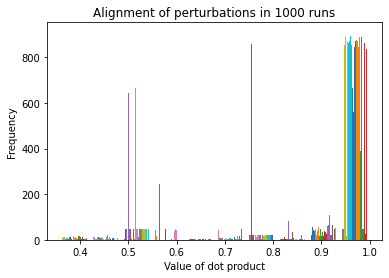

In [56]:
plt.hist(dot_products)
plt.xlabel("Value of dot product")
plt.ylabel("Frequency")
plt.title("Alignment of perturbations in 1000 runs")
plt.show()

In [46]:
labels.shape

torch.Size([1000, 8])

In [48]:
for i in range(labels.shape[1]):
    if not (labels[:, i] == labels[:, i][0]).all():
        print(i)

2
3
5


In [57]:
random_target[5], labels[:, 5]

(tensor(0.),
 tensor([4., 7., 5., 7., 7., 7., 7., 7., 7., 7., 4., 7., 7., 7., 7., 7., 7., 7.,
         7., 7., 7., 7., 7., 7., 4., 7., 5., 1., 7., 7., 7., 4., 7., 4., 7., 7.,
         5., 7., 3., 5., 7., 7., 7., 5., 7., 7., 7., 7., 7., 7., 7., 7., 7., 4.,
         4., 1., 7., 7., 1., 7., 7., 7., 7., 7., 7., 3., 7., 1., 7., 4., 7., 7.,
         4., 4., 7., 4., 7., 4., 7., 5., 1., 5., 4., 7., 4., 7., 4., 4., 7., 7.,
         7., 7., 5., 7., 4., 7., 7., 4., 7., 4., 7., 3., 7., 7., 7., 7., 4., 7.,
         7., 5., 7., 7., 7., 7., 7., 5., 7., 4., 7., 1., 7., 7., 4., 7., 7., 4.,
         7., 5., 7., 7., 4., 7., 5., 1., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
         7., 7., 4., 4., 7., 7., 7., 7., 7., 7., 7., 4., 7., 7., 7., 7., 4., 7.,
         1., 7., 1., 7., 7., 4., 4., 7., 7., 7., 4., 7., 7., 7., 7., 4., 7., 4.,
         7., 7., 7., 7., 7., 7., 7., 7., 5., 7., 5., 4., 4., 7., 7., 7., 7., 7.,
         1., 7., 7., 7., 7., 4., 7., 5., 7., 7., 7., 7., 7., 4., 7., 3., 4., 7.,
         5., 7.

# Scratch work

In [30]:
test_img = X_test[0]

In [37]:
torch.stack((X_test, X_test)).shape

torch.Size([2, 40000, 28, 28, 1])

In [15]:
y_test[0]

tensor(0.)

In [18]:
test_img_latent = pca.transform(test_img.reshape(1, -1))

In [19]:
nbhrs_idx = NN.kneighbors(test_img_latent, 50)[1][0]


In [20]:
nbhrs = X_train[nbhrs_idx]


In [21]:
test_imgs = X_test[0:5].cuda()
test_codes = y_test[0:5].cuda()
model = model.cuda()
delta = pgd_linf_rand(model, test_imgs, test_codes, 0.1, 1e-2, 40, 10)
model = model.cpu()
test_imgs = test_imgs.cpu()
test_codes = test_codes.cpu()

In [22]:
delta = delta.cpu()
eps = delta[0]
adv_img = test_img + eps

In [23]:
adv_img_latent = pca.transform(adv_img.reshape(1, -1))
nbhrs_idx = NN.kneighbors(test_img_latent, 50)[1][0]
nbhrs = X_train[nbhrs_idx]


In [24]:
 nbhrs.mean(axis=0).shape

(28, 28, 1)

In [25]:
tmp = nbhrs.reshape(nbhrs.shape[0], -1) - nbhrs.mean(axis=0).reshape(-1)
A = tmp.T



In [28]:
beta = np.linalg.lstsq(A, eps.reshape(-1), rcond=None)[0]


In [31]:
projection_img = np.dot(A, beta) + nbhrs.mean(axis=0).reshape(-1)
projection_img = projection_img.reshape(28, 28, 1) 

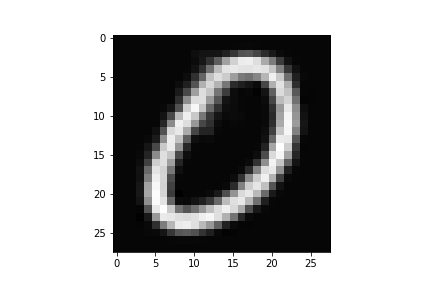

In [32]:
plt.figure()
plt.imshow(projection_img, cmap="gray")
plt.savefig("imgs/proj_test3.png")
Image(filename="imgs/proj_test3.png")




In [35]:
np.linalg.norm((projection_img - adv_img.numpy()).reshape(-1), 2)

5.3679113

In [36]:
np.linalg.norm(eps.reshape(-1), 2)

2.44857

In [34]:
test_input = torch.cat((torch.from_numpy(projection_img), adv_img), axis=0).cuda()
model = model.cuda()
logits = model(test_input)
labels = logits.max(axis=1)[1]
model = model.cpu()
test_input = test_input.cpu()
labels

tensor([0, 5], device='cuda:1')

array([[[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00]],

       [[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],

<IPython.core.display.Javascript object>


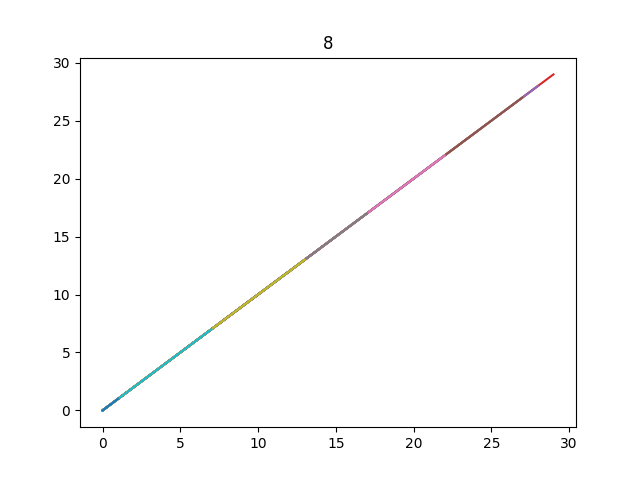

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

<function __main__.test(x=10)>